# Conditional DCGAN

In this experiment, we will learn to generate samples from a given labels using DCGAN. We saw that DCGAN architecure is generating sharper images than Vanilla GAN because the conv-layer of generator is helping it to understand the hierarchical structure in the images such as edges, corner etc. We would like to see if this behavior extends in the conditional DCGAN.   

## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

/home/abhishek/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset

Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


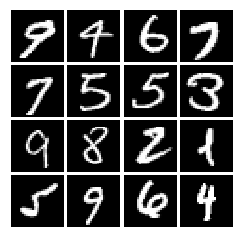

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=True)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## Random Noise

In [3]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    return tf.random_uniform([batch_size, dim], -1, 1)

In [4]:
def sample_labels(batch_size, dim):
    """Generate one hot random labels.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing one-hot labels with shape [batch_size, dim]
    """
    labels = tf.random_uniform([batch_size, dim], 0, 1)
    return tf.one_hot(tf.argmax(labels, axis=1), dim)

## Discriminator

We use the labels in the discriminator only at the fully connected layer. This is the trick that I learnt from [Deterministic Policy Gradient]() algorithm

In [5]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images along with its labels, shape [batch_size, 784 + 10]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        batch_size = tf.shape(x)[0]
        x_image = x[:, :784]
        x_label = x[:, 784:]
        x_image = tf.reshape(x_image, (batch_size, 28, 28, 1), name="reshape_3d")
        conv_1 = tf.layers.conv2d(x_image, filters=32, kernel_size=(5, 5), activation=tf.nn.leaky_relu, name="conv_1")
        pool_1 = tf.layers.max_pooling2d(conv_1, pool_size=(2, 2), strides=2, name="pool_1")
        conv_2 = tf.layers.conv2d(pool_1, filters=64, kernel_size=(5, 5), activation=tf.nn.leaky_relu, name="conv_2")
        pool_2 = tf.layers.max_pooling2d(conv_2, pool_size=(2, 2), strides=2, name="pool_2")
        flatten = tf.reshape(pool_2, shape=(batch_size, 64 * 16))
        flatten_label = tf.concat((flatten, x_label), axis=1)
        fc_1 = tf.layers.dense(flatten_label, 1024, name="fc_1", activation=tf.nn.leaky_relu)
        logits = tf.layers.dense(fc_1, 1, name="logits")
        return logits

## Generator

In [7]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim + label_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        fc1 = tf.layers.dense(z, 1024, tf.nn.relu)
        bn1 = tf.layers.batch_normalization(fc1)
        fc2 = tf.layers.dense(bn1, 7 * 7 * 128, tf.nn.relu)
        bn2 = tf.layers.batch_normalization(fc2)
        image_tensor = tf.reshape(bn2, (tf.shape(z)[0], 7, 7, 128))
        conv_T_1 = tf.layers.conv2d_transpose(image_tensor, filters=64, kernel_size=(4, 4), 
                                              strides=(2, 2), padding="same", activation=tf.nn.relu)
        bn3 = tf.layers.batch_normalization(conv_T_1)
        conv_T_2 = tf.layers.conv2d_transpose(bn3, filters=1, kernel_size=(4, 4), strides=(2, 2), 
                                               padding="same", activation=tf.nn.tanh)
        img = tf.reshape(conv_T_2, (-1,784))
    return img

## Conditon DCGAN Loss

In [8]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    ones_labels_d = tf.ones_like(logits_real) 
    zeros_labels_d = tf.zeros_like(logits_fake)
    
    ones_labels_g = tf.ones_like(logits_fake)
    
    real_data_predictions = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real, labels=ones_labels_d)
    fake_data_predictions = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=zeros_labels_d)
    D_loss = tf.reduce_mean(real_data_predictions) + tf.reduce_mean(fake_data_predictions)
    
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake, labels=ones_labels_g))
    return D_loss, G_loss

# Optimizing our loss

In [9]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)

    return D_solver, G_solver

## Putting it all together

In [10]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96
labels_dim = 10

# placeholder for images from the training dataset
x_image = tf.placeholder(tf.float32, [None, 784])
# scale images to be -1 to 1
x_image_preprocess = preprocess_img(x_image)
# placeholders for labels
x_label = tf.placeholder(tf.float32, [None, labels_dim])
# concate labels and images
x = tf.concat((x_image_preprocess, x_label), axis=1)

# random image_noise fed into our generator
z_image = sample_noise(batch_size, noise_dim)
# random label_nose fed into the generator
z_label = sample_labels(batch_size, labels_dim)
# concat image and noise
z = tf.concat((z_image, z_label), axis=1)

# generated images
G_sample = generator(z)
# concat generated images with fake labels
G_sample_with_labels = tf.concat((G_sample, z_label), axis=1)

with tf.variable_scope("") as scope:
    logits_real = discriminator(x)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample_with_labels)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!

In [11]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(deprocess_img(samples[:16]))
            plt.show()
            print()
        # run a batch of data through the network
        minibatch_x, minibatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x_image: minibatch_x,
                                                                     x_label: minibatch_y})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(deprocess_img(samples[:16]))
    plt.show()

## Train Conditional DCGAN! 

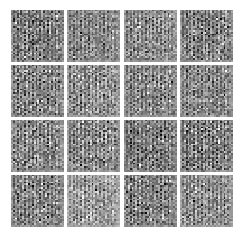


Iter: 0, D: 1.407, G:0.6535
Iter: 50, D: 0.9257, G:3.476
Iter: 100, D: 0.1312, G:3.105
Iter: 150, D: 0.09745, G:3.626
Iter: 200, D: 0.8237, G:3.324


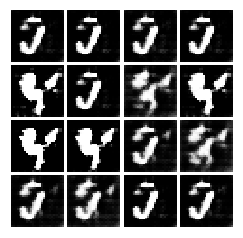


Iter: 250, D: 0.5874, G:3.38
Iter: 300, D: 1.077, G:3.062
Iter: 350, D: 0.4248, G:5.585
Iter: 400, D: 0.6288, G:2.358
Iter: 450, D: 0.6466, G:4.152


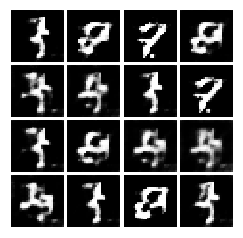


Iter: 500, D: 1.032, G:2.12
Iter: 550, D: 1.157, G:1.738
Iter: 600, D: 0.4004, G:3.377
Iter: 650, D: 0.4324, G:3.219
Iter: 700, D: 0.6785, G:1.93


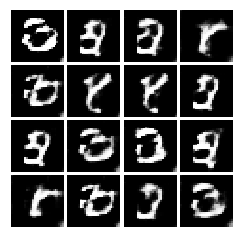


Iter: 750, D: 0.4056, G:3.173
Iter: 800, D: 0.3753, G:3.987
Iter: 850, D: 0.267, G:3.509
Iter: 900, D: 0.5333, G:2.911
Iter: 950, D: 0.5792, G:3.139


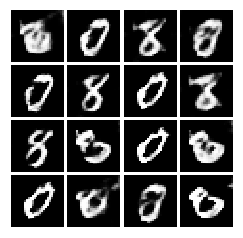


Iter: 1000, D: 0.3749, G:2.922
Iter: 1050, D: 0.3297, G:3.935
Iter: 1100, D: 0.5854, G:2.29
Iter: 1150, D: 0.3429, G:3.703
Iter: 1200, D: 0.4742, G:2.866


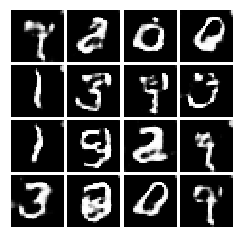


Iter: 1250, D: 0.8071, G:1.715
Iter: 1300, D: 1.023, G:1.253
Iter: 1350, D: 0.9866, G:3.472
Iter: 1400, D: 0.8251, G:1.644
Iter: 1450, D: 0.7791, G:1.811


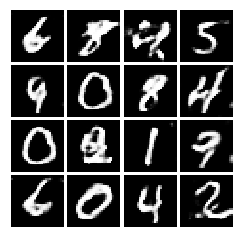


Iter: 1500, D: 0.9045, G:1.879
Iter: 1550, D: 1.009, G:1.06
Iter: 1600, D: 0.9625, G:1.641
Iter: 1650, D: 1.107, G:1.549
Iter: 1700, D: 0.8519, G:1.719


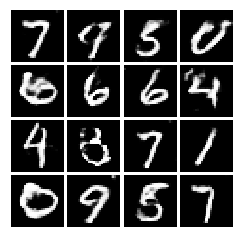


Iter: 1750, D: 0.9288, G:1.014
Iter: 1800, D: 1.111, G:2.924
Iter: 1850, D: 0.9542, G:1.788
Iter: 1900, D: 0.967, G:1.438
Iter: 1950, D: 1.117, G:0.9487


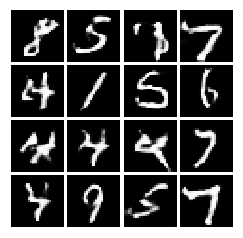


Iter: 2000, D: 1.231, G:1.542
Iter: 2050, D: 1.055, G:1.217
Iter: 2100, D: 0.9006, G:1.283
Iter: 2150, D: 0.9652, G:1.229
Iter: 2200, D: 1.098, G:1.734


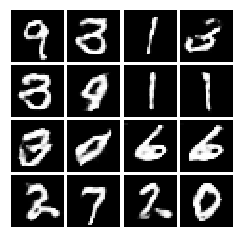


Iter: 2250, D: 0.9504, G:1.356
Iter: 2300, D: 0.9915, G:1.333
Iter: 2350, D: 0.9427, G:1.183
Iter: 2400, D: 1.166, G:1.051
Iter: 2450, D: 1.117, G:1.136


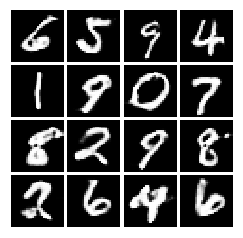


Iter: 2500, D: 1.133, G:1.279
Iter: 2550, D: 1.099, G:1.379
Iter: 2600, D: 1.033, G:0.9967
Iter: 2650, D: 1.334, G:0.9381
Iter: 2700, D: 1.055, G:1.089


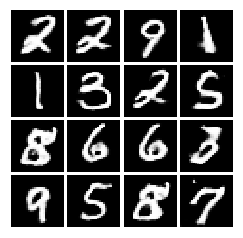


Iter: 2750, D: 1.052, G:1.399
Iter: 2800, D: 1.026, G:1.301
Iter: 2850, D: 1.054, G:1.027
Iter: 2900, D: 0.9984, G:1.498
Iter: 2950, D: 1.031, G:1.705


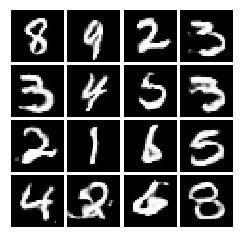


Iter: 3000, D: 0.9068, G:1.174
Iter: 3050, D: 0.8309, G:1.369
Iter: 3100, D: 1.027, G:1.492
Iter: 3150, D: 1.115, G:0.9894
Iter: 3200, D: 1.192, G:2.124


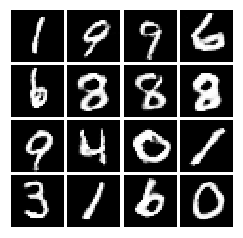


Iter: 3250, D: 1.123, G:2.214
Iter: 3300, D: 0.9905, G:1.17
Iter: 3350, D: 1.008, G:1.344
Iter: 3400, D: 0.9016, G:1.621
Iter: 3450, D: 0.9386, G:1.55


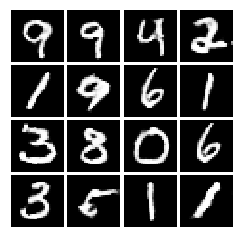


Iter: 3500, D: 1.039, G:1.203
Iter: 3550, D: 0.881, G:1.189
Iter: 3600, D: 0.9679, G:1.309
Iter: 3650, D: 0.9836, G:1.655
Iter: 3700, D: 1.038, G:1.049


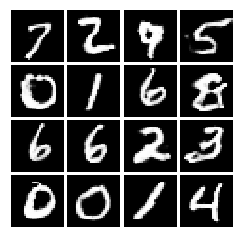


Iter: 3750, D: 0.9399, G:1.25
Iter: 3800, D: 1.358, G:1.984
Iter: 3850, D: 0.8275, G:1.787
Iter: 3900, D: 0.827, G:1.61
Iter: 3950, D: 0.8435, G:1.275


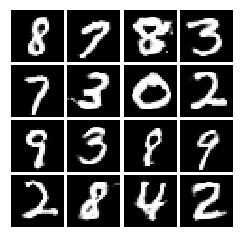


Iter: 4000, D: 0.8943, G:1.156
Iter: 4050, D: 0.8688, G:1.595
Iter: 4100, D: 0.9907, G:1.966
Iter: 4150, D: 0.9004, G:1.284
Iter: 4200, D: 1.285, G:2.437


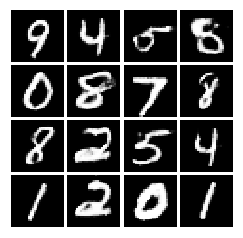


Iter: 4250, D: 1.134, G:2.067
Final images


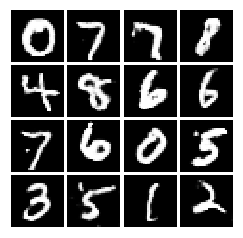

In [12]:
sess = get_session()
sess.run(tf.global_variables_initializer())
run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Conclusion

We see the images are generated and they look good. There is a dot point near $7$ and $5$. That is an interesting artifact that appeared in the later part of training. 

# Showing that Conditional DCGAN is able to generate the similar looking images by using the labels

In [13]:
def get_fixed_labels(batch_size, label_num):
    """
    Generate the labels to use in the Conditional GAN
    """
    labels = np.zeros((batch_size, 10))
    labels[np.arange(batch_size), label_num] = 1
    return labels

### Generating samples similar to digit $7$

** In the below code, I am using the trick that you can pass values to a tensorflow variables**

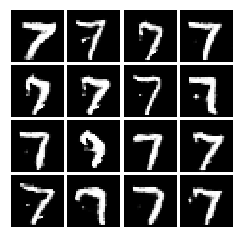

In [14]:
samples = sess.run(G_sample, feed_dict={z_label:get_fixed_labels(batch_size, 7)})
fig = show_images(samples[:16])
plt.show()

** Conclusion:** As previously, there is some but comparitively little confusion between $7$ and $9$.

### Generating samples similar to digit $3$

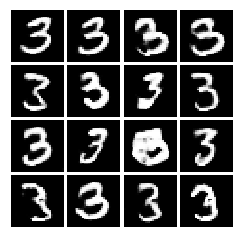

In [15]:
samples = sess.run(G_sample, feed_dict={z_label:get_fixed_labels(batch_size, 3)})
fig = show_images(samples[:16])
plt.show()